<a href="https://colab.research.google.com/github/xAn-x/Duplicate-Question-Pairs/blob/master/Duplicate_Question_Pairs_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np

## Import Dataset

In [70]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
ds_path="/content/drive/MyDrive/Datasets/quora-question-pairs/questions.csv"

nrows=None
df=pd.read_csv(ds_path,nrows=nrows)

In [72]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [74]:
df.dropna(inplace=True)

In [75]:
import torch
import torchtext
from torchtext.data import get_tokenizer

In [76]:
tokenizer=get_tokenizer("basic_english")

In [77]:
lst=tokenizer(df["question1"][0])
print(lst)

['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?']


In [78]:
## Build Vocab

In [79]:
import nltk
from nltk.corpus import stopwords

In [80]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
stop_words=stopwords.words("english")

", ".join(stop_words)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [82]:
req_words="i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just"
selected_stop_words=set(req_words.split(", "))

In [83]:
def build_vocab(df):
  tokenized1=tokenizer(df["question1"])
  tokenized2=tokenizer(df["question2"])

  tokenized1=[word for word in tokenized1 if word not in selected_stop_words]
  tokenized2=[word for word in tokenized2 if word not in selected_stop_words]


  return tokenized1+tokenized2

In [84]:
merged_questions=df.apply(build_vocab,axis=1)

In [85]:
merged_questions[0]

['step',
 'step',
 'guide',
 'invest',
 'share',
 'market',
 'india',
 '?',
 'step',
 'step',
 'guide',
 'invest',
 'share',
 'market',
 '?']

In [86]:
VOCAB_SIZE=7000
specials=["<unknown>","<pad>","<q1_st>","<q2_st>","<q1_end>","<q2_end>"]

In [87]:
vocab=torchtext.vocab.build_vocab_from_iterator(merged_questions,specials=specials,max_tokens=VOCAB_SIZE)

In [88]:
# Mapping if wor is not +nt in vocab
vocab.set_default_index(0)

In [89]:
# Getting the int-encoding corresponding to a string
vocab.lookup_indices(["laptop","<q1_st>","components"])

[179, 2, 2947]

In [90]:
# Getting corresponding string using int-encoding
vocab.lookup_tokens([267, 4, 0])

['mechanical', '<q1_end>', '<unknown>']

## Creating Dataset

In [91]:
import matplotlib.pyplot as plt

# Find the length of the merged_questions list
no_of_questions=200_000
merged_questions_len=np.array(list(map(len,merged_questions[:no_of_questions])))

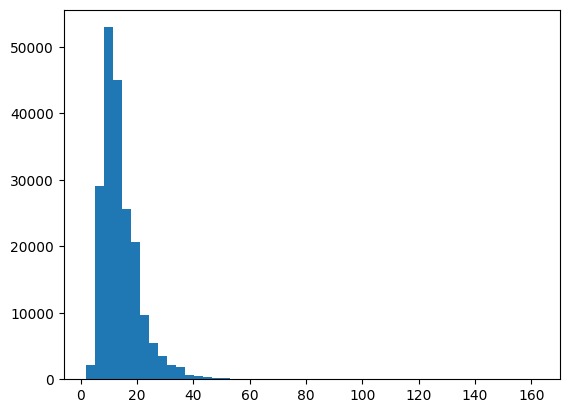

In [92]:
plt.hist(merged_questions_len,bins=50)
plt.show()

In [93]:
# Max questions has len around 30 , so using 45 as a general length for each sequence will cover maximum

In [94]:
from torch.utils.data import Dataset
class DupQuestionPair(Dataset):
  def __init__(self,dataframe,tokenizer,vocab,max_len=45,stop_words=None):
    super(DupQuestionPair,self).__init__()
    self.dataframe=dataframe
    self.vocab=vocab
    self.tokenizer=tokenizer
    self.max_len=max_len
    self.stop_words=stop_words

  def __getitem__(self,idx):
    input=self.get_input(idx)
    # Return input and output
    return torch.tensor(input),torch.tensor([df.iloc[idx,-1]]).float()

  def __len__(self):
    return len(self.dataframe)

  def get_input(self,idx):
    # Get Questions
    q1=self.dataframe.iloc[idx,-3]
    q2=self.dataframe.iloc[idx,-2]

    # Tokenize questions
    q1_tokenized=self.tokenizer(q1)
    q2_tokenized=self.tokenizer(q2)

    if stop_words:
      q1_tokenized=[word for word in q1_tokenized if word not in self.stop_words]
      q2_tokenized=[word for word in q1_tokenized if word not in self.stop_words]


    # Merge questions
    merged_lst= ["<q1_st>"]+q1_tokenized+["<q1_end>","<q2_st>"]+q2_tokenized+["<q2_end>"]

    # pad
    n=len(merged_lst)
    if n >= self.max_len:
      merged_lst=merged_lst[:self.max_len]
    else:
       merged_lst=merged_lst+["<pad>"]*(self.max_len-n)

    # Numerical encoder and return
    return self.vocab.lookup_indices(merged_lst)

In [95]:
dataset=DupQuestionPair(df,tokenizer,vocab,stop_words=selected_stop_words)

In [96]:
# res=dataset[11292]
# res

## Train-Test split

In [97]:
from torch.utils.data import random_split

n=len(dataset)

train_len = int(0.9 * n)
val_len=n-train_len
# test_len=n-val_len-train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

In [98]:
print("Train Dataset: ",len(train_dataset))
print("Validation Dataset: ",len(val_dataset))
# print("Test Dataset: ",len(test_dataset))

Train Dataset:  363913
Validation Dataset:  40435


## Create DataLoaders

In [99]:
BATCH_SIZE=512


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,num_workers=2,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE*2,num_workers=2,pin_memory=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE*2,num_workers=2,pin_memory=True)

In [100]:
for batch in train_dataloader:
  batch_inp,batch_out=batch
  print("Input-shape: ",batch_inp.shape)
  print("Output-shape: ",batch_out.shape)
  break

Input-shape:  torch.Size([512, 45])
Output-shape:  torch.Size([512, 1])


Model Creation

In [101]:
!pip install lightning --quiet

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

In [115]:
class DupQuestionPairModel(L.LightningModule):
  def __init__(self,learning_rate=0.01,num_layers=2,bidirectional=False):
    super(DupQuestionPairModel,self).__init__()

    # ------------ Layers ------------
    self.learning_rate=learning_rate
    self.embedding=nn.Embedding(VOCAB_SIZE,256,padding_idx=1)
    out=256
    self.lstm=nn.LSTM(256,out,num_layers,batch_first=True,bidirectional=bidirectional)
    n=out*2 if bidirectional else out
    self.fc1=nn.Linear(n,64)
    self.fc2=nn.Linear(64,1)

    # ------------ results ------------
    self.training_step_outputs={"losses":[],"accuracies":[]}
    self.validation_step_outputs={"losses":[],"accuracies":[]}
    self.history={"training_loss":[],"training_accuracy":[],"validation_loss":[],"validation_accuracy":[]}


  def forward(self,xb):
    out=self.embedding(xb)
    out,(h,c)=self.lstm(out)
    out=F.relu(out[:,-1,:])
    out=self.fc1(out)
    out=self.fc2(out)
    return out


  def common_step(self,batch,batch_idx):
    inputs,targets=batch
    y_hat=F.sigmoid(self(inputs))
    loss=F.binary_cross_entropy(y_hat,targets)
    return loss,y_hat

  def training_step(self, batch, batch_idx):
        loss,y_hat=self.common_step(batch,batch_idx)
        self.training_step_outputs["losses"].append(loss.item())
        self.training_step_outputs["accuracies"].append(self.get_accuracy(y_hat,batch[1]))
        return loss

  def validation_step(self, batch, batch_idx):
        loss,y_hat=self.common_step(batch,batch_idx)
        self.validation_step_outputs["losses"].append(loss.item())
        self.validation_step_outputs["accuracies"].append(self.get_accuracy(y_hat,batch[1]))
        return loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
      loss,y_hat=self.common_step(batch,batch_idx)
      return y_hat

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer



  # ------------------ LOGGING RESULTS ------------------------------
  def on_train_epoch_end(self):
    losses = [loss for loss in self.training_step_outputs["losses"]]
    accuracies = [accuracy for accuracy in self.training_step_outputs["accuracies"]]

    mean_loss, mean_accuracy = np.mean(losses), np.mean(accuracies)

    print(f"\nEpoch {self.current_epoch} Training Summary:")
    print(f"   - Loss: {mean_loss:.4f}")
    print(f"   - Accuracy: {mean_accuracy:.2%}\n")

    self.history["training_loss"].append(mean_loss)
    self.history["training_accuracy"].append(mean_accuracy)

    # Reset for the next epoch
    self.training_step_outputs = {"losses": [], "accuracies": []}

  def on_validation_epoch_end(self):
    losses = [loss for loss in self.validation_step_outputs["losses"]]
    accuracies = [accuracy for accuracy in self.validation_step_outputs["accuracies"]]

    mean_loss, mean_accuracy = np.mean(losses), np.mean(accuracies)

    print(f"\nEpoch {self.current_epoch} Validation Results:")
    print(f"   - Loss: {mean_loss:.4f}")
    print(f"   - Accuracy: {mean_accuracy:.2%}\n")

    self.history["validation_loss"].append(mean_loss)
    self.history["validation_accuracy"].append(mean_accuracy)

    # Reset for the next epoch
    self.validation_step_outputs = {"losses": [], "accuracies": []}

  def get_accuracy(self,y_hat,targets):
    preds=torch.where(y_hat>=0.5,1,0)
    accuracy=torch.sum(preds==targets)/len(targets)
    return accuracy.item()

In [116]:
# Instantiate your model
steps_per_epoch=len(train_dataloader)
model = DupQuestionPairModel(learning_rate=0.01, num_layers=2, bidirectional=True)

model

DupQuestionPairModel(
  (embedding): Embedding(7000, 256, padding_idx=1)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [117]:
# Instantiate the Trainer
trainer = L.Trainer(
    max_epochs=5,
    fast_dev_run=False
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [118]:
trainer.fit(model,train_dataloader,val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.8 M 
1 | lstm      | LSTM      | 2.6 M 
2 | fc1       | Linear    | 32.8 K
3 | fc2       | Linear    | 65    
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.818    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.8 M 
1 | lstm      | LSTM      | 2.6 M 
2 | fc1       | Linear    | 32.8 K
3 | fc2       | Linear    | 65    
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.818    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch 0 Validation Results:
   - Loss: 0.6993
   - Accuracy: 36.43%



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 0 Validation Results:
   - Loss: 0.5454
   - Accuracy: 72.62%


Epoch 0 Training Summary:
   - Loss: 0.6143
   - Accuracy: 67.05%



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 1 Validation Results:
   - Loss: 0.5292
   - Accuracy: 74.15%


Epoch 1 Training Summary:
   - Loss: 0.5314
   - Accuracy: 73.93%



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 2 Validation Results:
   - Loss: 0.5190
   - Accuracy: 74.71%


Epoch 2 Training Summary:
   - Loss: 0.5096
   - Accuracy: 75.32%



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 3 Validation Results:
   - Loss: 0.5130
   - Accuracy: 74.83%


Epoch 3 Training Summary:
   - Loss: 0.4971
   - Accuracy: 75.96%



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 4 Validation Results:
   - Loss: 0.5142
   - Accuracy: 75.05%


Epoch 4 Training Summary:
   - Loss: 0.4901
   - Accuracy: 76.36%



INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [119]:
def plot_metric(history:dict,metric:str):
  plt.plot(history[f"training_{metric}"],"rx-",label=f"Training-{metric}")
  plt.plot(history[f"validation_{metric}"],"b*--",label=f"Validation-{metric}")
  plt.legend()
  plt.show()

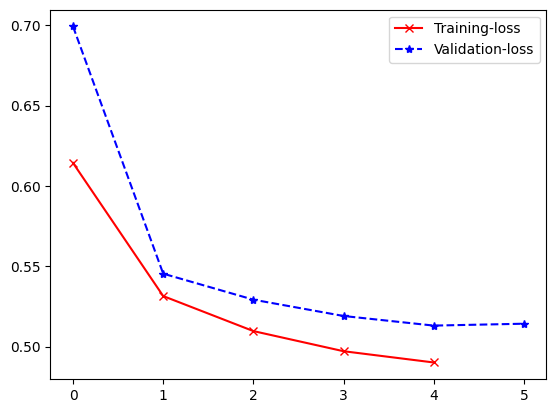

In [120]:
plot_metric(model.history,"loss")

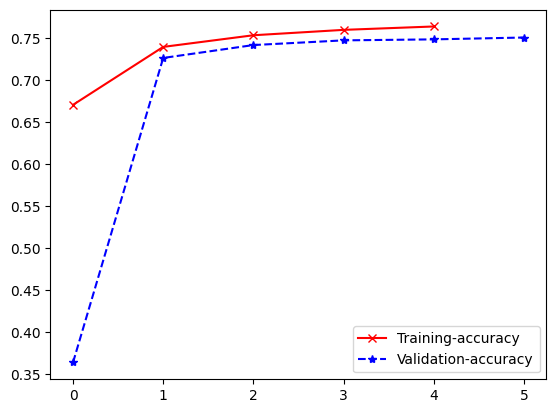

In [121]:
plot_metric(model.history,"accuracy")

In [122]:
new_trainer=L.Trainer(max_epochs=3)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [123]:
new_trainer.fit(model,train_dataloader,val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.8 M 
1 | lstm      | LSTM      | 2.6 M 
2 | fc1       | Linear    | 32.8 K
3 | fc2       | Linear    | 65    
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.818    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.8 M 
1 | lstm      | LSTM      | 2.6 M 
2 | fc1       | Linear    | 32.8 K
3 | fc2       | Linear    | 65    
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.818    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch 0 Validation Results:
   - Loss: 0.5228
   - Accuracy: 74.61%



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 0 Validation Results:
   - Loss: 0.5138
   - Accuracy: 75.06%


Epoch 0 Training Summary:
   - Loss: 0.4801
   - Accuracy: 77.03%



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 1 Validation Results:
   - Loss: 0.5096
   - Accuracy: 75.39%


Epoch 1 Training Summary:
   - Loss: 0.4752
   - Accuracy: 77.28%



Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.



Epoch 2 Validation Results:
   - Loss: 0.5132
   - Accuracy: 75.13%


Epoch 2 Training Summary:
   - Loss: 0.4716
   - Accuracy: 77.48%



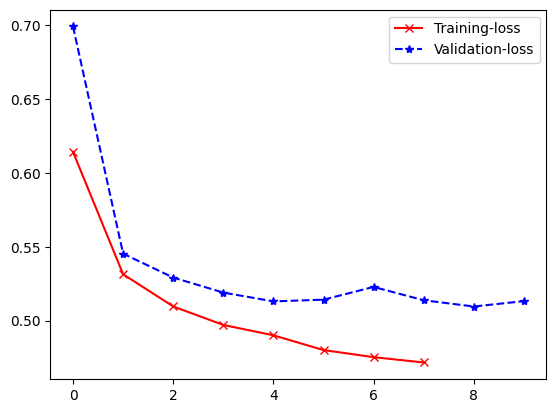

In [124]:
plot_metric(model.history,"loss")

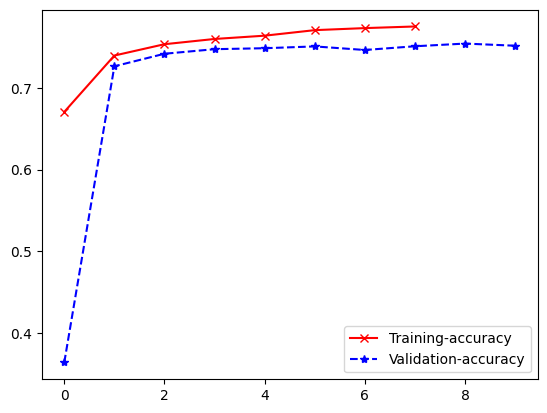

In [125]:
plot_metric(model.history,"accuracy")

In [126]:
# prompt: save my model
ds_path="/content/drive/MyDrive/Datasets/quora-question-pairs"
torch.save(model.state_dict(), ds_path+"/qqp_torch_model.pt")